In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt

# Text Encoding

1. hot encoding : for each word, vectorize the word to a vector of vocabulary length and 99% of it is 0s. *Insufficient*!!

2. encode to numbers: 
  - it's hard to learn the relationship between each word
  - hard to interpret

3. Work embedding: 
  - dense and efficient way to represent a word. similiar words can be embedded similiarly
  - you can train it (the more dimensions - you can specify it, the more data required to train)







In [ ]:
batch_size = 1024
seed = 123
vocab_size = 1000
embedding_size = 16
sequence_length = 250

In [ ]:
#Load IMDB datasets
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

#remove a directory called unsup in train dir
remove_dir = os.path.join(dataset_dir, 'train','unsup')
shutil.rmtree(remove_dir)

print(os.listdir(dataset_dir))
print(os.listdir(os.path.join(dataset_dir, "train")))
print(os.listdir(os.path.join(dataset_dir, "test")))

84125825/84125825 [==============================] - 4s 0us/step
['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']
['neg', 'urls_pos.txt', 'pos', 'unsupBow.feat', 'urls_neg.txt', 'labeledBow.feat', 'urls_unsup.txt']
['neg', 'urls_pos.txt', 'pos', 'urls_neg.txt', 'labeledBow.feat']


In [ ]:
#Load dataset to train_ds, valid_ds
train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    batch_size = batch_size, 
    subset="training",
    seed = seed,
    validation_split=0.2
    )

valid_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    batch_size = batch_size, 
    subset="validation",
    seed = seed,
    validation_split=0.2
    )
test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    batch_size=batch_size,
    shuffle=False,
)

#EDA
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print("labels ", train_ds.class_names)



Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Review b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
Label 0
Review b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high school

In [ ]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Now vectorize the dataset using TextVectorization

In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def standardize_func(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')
  
 
vectorization_layer = tf.keras.layers.TextVectorization(
    standardize=standardize_func,
    max_tokens = vocab_size,
    output_sequence_length = sequence_length,
    output_mode = 'int',

)

#Processed train_ds
p_train_ds = train_ds.map(lambda x, y: x)
vectorization_layer.adapt(p_train_ds)

In [ ]:
#Now just visualize what vectorization layer does
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorization_layer(text), label

x, y = next(iter(train_ds))
print(x[0], 'shape=', x[0].shape)
print(y[0])
print(vectorize_text(x,y))

In [ ]:
#Just check the vocabulary in from vectorization layer
print(f'{253}-->{vectorization_layer.get_vocabulary()[253]}')
print(f'{998}-->{vectorization_layer.get_vocabulary()[998]}')
print(f'vocab size: {len(vectorization_layer.get_vocabulary())}')

### Now prepare for training


In [ ]:
#Configure dataset object for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


In [ ]:
#Define the model

model = tf.keras.models.Sequential([
    vectorization_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_size, name='embedding'),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoint', verbose = 1,save_best_only=True)

history = model.fit(train_ds, validation_data=valid_ds, epochs = 100, callbacks=[checkpoint_cb])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5028
Epoch 1: val_loss improved from inf to 0.69162, saving model to ./checkpoint
20/20 [==============================] - 10s 244ms/step - loss: 0.6925 - accuracy: 0.5028 - val_loss: 0.6916 - val_accuracy: 0.4886
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6906 - accuracy: 0.5028
Epoch 2: val_loss improved from 0.69162 to 0.68903, saving model to ./checkpoint
20/20 [==============================] - 2s 92ms/step - loss: 0.6906 - accuracy: 0.5028 - val_loss: 0.6890 - val_accuracy: 0.4886
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.5028
Epoch 3: val_loss improved from 0.68903 to 0.68491, saving model to ./checkpoint
20/20 [==============================] - 2s 101ms/step - loss: 0.6874 - accuracy: 0.5028 - val_loss: 0.6849 - val_accuracy: 0.4886
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.6823 - accur

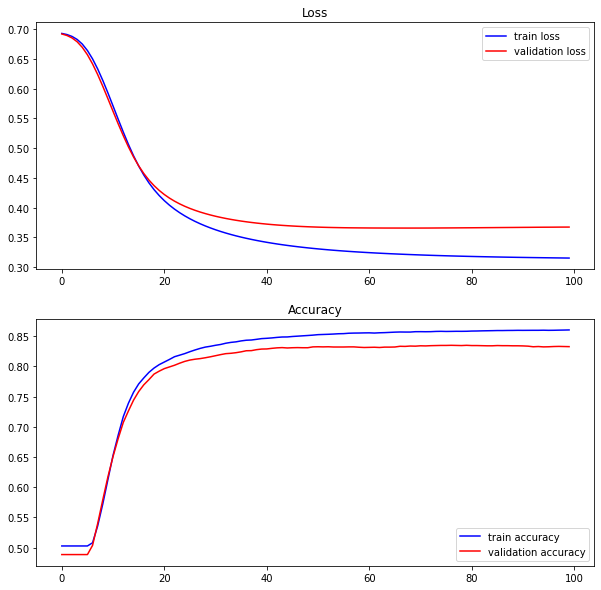

In [ ]:
def summarize_diagnostic(history, path = '', description = None):
    plt.figure(figsize=(10,10))
    plt.figtext(0, 1, description, fontsize=15)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.savefig(path, dpi = 100, bbox_inches = 'tight')
    
summarize_diagnostic(history)

In [ ]:
 1